In [1]:
from ipynb.fs.full.Functions import *

In [2]:
from scipy import optimize

# Changed functions for this exercise 

In [3]:
def get_Q_arr(Ws=5e-4, alpha=1e-4, Kv=1e-2, phaseD1=0, phaseM2=0, phaseM4=np.pi/2, ampD1=0, ampM2=1, ampM4=0.2): #Define amp D1 M2 and M4 in calling function 
    '''
    Function to get time, C and Q. 
    Input:
        Ws = 
        alpha = 
        Kv = 
    Output: 
        t = 
        C = 
        Q = 
    '''

    T = (12*60+25)*60        # We model only the M2 and M4 tide. Time is in seconds. 
    Tadapt = Kv/Ws**2
    Test = 3*Tadapt          # Estimated adaptation time scale to get to equilibrium C
    Tnt  = np.ceil(Test/T)
    Tend = 3*Tnt*T           # Depends on Ws and Kv. Enough time to Equilibrium C. 
    deltaT = 300             # Time step of 5 minutes
    t  = np.arange(0, Tend+deltaT, deltaT)
    Nt = len(t)

#Since this is specified in the calling of the function, so I commented it here 
#     ampD1 = 0            # in part 1 and 2 D1=0. Depending on your estuary, you might want to prescribe D1 for part 3. 
#     ampM2 = 1
#     ampM4 = 0.2
    
    Z = ampD1*np.sin(np.pi*t/T + phaseD1)+ ampM2*np.sin(2*np.pi*t/T + phaseM2)+ ampM4*np.sin(4*np.pi*t/T + phaseM4)          # Waterlevel prescribed as sine function. 
    dZdt = ampD1*1*np.pi/T*np.cos(np.pi*t/T+ phaseD1)+ ampM2*2*np.pi/T*np.cos(2*np.pi*t/T+ phaseM2)+ ampM4*4*np.pi/T*np.cos(4*np.pi*t/T + phaseM4)  # Flow velocity will behave as a cosine function. 
    
    L  = 1e4                     # We model a simple basin with a length of 10 km
    dx = 400                     # Grid distance
    x  = np.arange(0, L+dx, dx)  # x-coordinate. Seaward end is at x=L, landward end at x=0. 
    Nx = len(x)                  # array of 26 long
    H = 10-8e-4 * x             # Bottom profile. Linear sloping bottom. 2 m deep near landward boundary, 10 m deep near inlet. 
    dHdx = np.ones(Nx) * -8e-4

    U = HydroModel(t,Z,dZdt,H,dHdx,x,dx) # Calculating flow velocities 

    Cgroen = np.zeros((Nx, Nt))
    Qsgroen = np.zeros((Nx,Nt))
    
    for px in range(Nx):
        Cgroen[px,0:Nt],Qsgroen[px,0:Nt] = GroenModel(U[px,0:Nt],t,deltaT, T, Ws, alpha, Kv) #using groens model to find C and Q
        
    Nsteps = T/deltaT       # Nr of timesteps in one tidal cycle. #added 
    final_cycle = int(-Nsteps) #added
    meanQsgroen = np.mean(Qsgroen[:,final_cycle:], 1) #added
    return t, Cgroen, Qsgroen, U, meanQsgroen

In [4]:
def FullModel(U, t, deltaT, T, Ws, alpha, Kv, dQsdx):
    """ 
    function GroenModel

    INPUT:
        U = depth averaged flow velocity in m/s
        t = time in s
        deltaT = timestep in s
        T = Timescale in s
        Ws = 'fall velocity' in m/s 
        alpha = 'erosion parameter' in kg s/m^4
        Kv = vertical eddy diffusivity m^2/s

    OUTPUT:
        Conc = 'the depth-integrated sediment concentration'
        q = 'sediment transport in  'kg m/s'
    """
    Tend = t[-1]
    deltaTfix = Kv / Ws**2  # Maximum time step allowed
    
    if deltaTfix > deltaT:
        deltaTfix = deltaT
    else:
        deltaT = deltaTfix
        
    # Within the code deltaT can be time dependent. Most often deltaTfix will be used. 
    
    Nt = int(np.ceil(Tend/deltaT) + 1)
    deltaTnew = Tend / Nt

    tt = np.arange(0, Tend + deltaTnew, deltaTnew)
    
    set_interp_U = interp1d(t, U, kind = 'linear') #Change name to U specific
    Uf = set_interp_U(tt) #Change name to U specific
    
    set_interp_Qs = interp1d(t, dQsdx, kind = 'linear') #Add interpolation for dQsdx
    dQsdxf = set_interp_Qs(tt) #Add interpolation for dQsdx
    
    E = np.zeros(Nt+1)
    D = np.zeros(Nt+1)
    C = np.zeros(Nt+1)
    
    # initialise solution at t=0
    tt[0] = t[0]
    C[0]  = 0.0
    
    for k in range(Nt):
        
        # ************************************************

        # Predictor step

        E[k] = alpha*Uf[k]**2
        D[k] = (Ws**2/Kv) * C[k]
        
        # New C will be caused by difference between erosion and deposition
        C[k+1] = C[k] + (E[k]-D[k]-dQsdxf[k])*deltaT #Added dQsdx
        
        # End of predictor step
        # *********************************************
        
        # *****************************************************************
        # Corrector step. See assignment. 
        
        E[k+1] = alpha*Uf[k+1]**2
        D[k+1] = (Ws**2/Kv)*C[k+1] 
        C[k+1] = C[k] + 0.5*(E[k]+E[k+1]-D[k]-D[k+1] -dQsdxf[k] - dQsdxf[k+1])*deltaT #Added dQsdx 
        
        # End of corrector step
        #*********************************************

        
    # Since we have calculated the solution on a new time vector, we have to interpolate the solution to the right time vector. 
    set_interp = interp1d(tt, C, kind = 'linear')
    Conc = set_interp(t)
    q = U*Conc
    return Conc, q

In [5]:
def get_Q_arr_full(Ws=5e-4, alpha=1e-4, Kv=1e-2, phaseD1=0, phaseM2=0, phaseM4=np.pi/2, ampD1=0, ampM2=1, ampM4=0.2): #Define amplitude in calling of function 
    '''
    Function to get time, C and Q. 
    Input:
        Ws = 
        alpha = 
        Kv = 
    Output: 
        t = 
        C = 
        Q = 
    '''

    T = (12*60+25)*60        # We model only the M2 and M4 tide. Time is in seconds. 
    Tadapt = Kv/Ws**2
    Test = 3*Tadapt          # Estimated adaptation time scale to get to equilibrium C
    Tnt  = np.ceil(Test/T)
    Tend = 3*Tnt*T           # Depends on Ws and Kv. Enough time to Equilibrium C. 
    deltaT = 300             # Time step of 5 minutes
    t  = np.arange(0, Tend+deltaT, deltaT)
    Nt = len(t)

#Comment the amplitude here, since it is already specified in the calling of the function 
#     ampD1 = 0            # in part 1 and 2 D1=0. Depending on your estuary, you might want to prescribe D1 for part 3. 
#     ampM2 = 1
#     ampM4 = 0.2
    
    Z = ampD1*np.sin(np.pi*t/T + phaseD1)+ ampM2*np.sin(2*np.pi*t/T + phaseM2)+ ampM4*np.sin(4*np.pi*t/T + phaseM4)          # Waterlevel prescribed as sine function. 
    dZdt = ampD1*1*np.pi/T*np.cos(np.pi*t/T+ phaseD1)+ ampM2*2*np.pi/T*np.cos(2*np.pi*t/T+ phaseM2)+ ampM4*4*np.pi/T*np.cos(4*np.pi*t/T + phaseM4)  # Flow velocity will behave as a cosine function. 
    
    L  = 1e4                     # We model a simple basin with a length of 10 km
    dx = 400                     # Grid distance
    x  = np.arange(0, L+dx, dx)  # x-coordinate. Seaward end is at x=L, landward end at x=0. 
    Nx = len(x)                  # array of 26 long
    H = 10-8e-4 * x             # Bottom profile. Linear sloping bottom. 2 m deep near landward boundary, 10 m deep near inlet. 
    dHdx = np.ones(Nx) * -8e-4

    U = HydroModel(t,Z,dZdt,H,dHdx,x,dx) # Calculating flow velocities 
    
    Cgroen = np.zeros((Nx, Nt))
    Qsgroen = np.zeros((Nx,Nt))
    
    for px in range(Nx):
        Cgroen[px,0:Nt],Qsgroen[px,0:Nt] = GroenModel(U[px,0:Nt],t ,deltaT, T, Ws, alpha, Kv) #using groens model to find C and Q
    
    dQsdx, dQsdt = np.gradient(Qsgroen, dx, deltaT) #Calculate the gradient of Qs based on Groen's model 
    
    Cfull = np.zeros((Nx, Nt)) #Make empty lists for the full model 
    Qsfull = np.zeros((Nx, Nt)) #Make empty lists for the full model 
    
    #Run the full model 
    for px in range(Nx):
        Cfull[px,0:Nt],Qsfull[px,0:Nt] = FullModel(U[px,0:Nt],t,deltaT, T, Ws, alpha, Kv, dQsdx[px,0:Nt]) #using groens model to find C and Q
    
    Nsteps = T/deltaT       # Nr of timesteps in one tidal cycle. #added 
    final_cycle = int(-Nsteps) #added
    meanQsfull = np.mean(Qsfull[:,final_cycle:], 1) #added
    return t, Cfull, Qsfull, U, meanQsfull

# A. run groen's model and full model for 0 and 90 degrees 

In [6]:
#Run full model and groen's model for 0 and 90 degrees 
tfull0, Cfull0, Qsfull0, Ufull0, Qsmeanfull0 = get_Q_arr_full(Ws=1e-3, alpha=1e-4, Kv=1e-2, phaseD1=0, phaseM2=0, phaseM4=0)
tgroen0, Cgroen0, Qsgroen0, Ugroen0, Qsmeangroen0 = get_Q_arr(Ws=1e-3, alpha=1e-4, Kv=1e-2, phaseD1=0, phaseM2=0, phaseM4=0)
tfull90, Cfull90, Qsfull90, Ufull90, Qsmeanfull90 = get_Q_arr_full(Ws=1e-3, alpha=1e-4, Kv=1e-2, phaseD1=0, phaseM2=0, phaseM4=np.pi/2)
tgroen90, Cgroen90, Qsgroen90, Ugroen90, Qsmeangroen90 = get_Q_arr(Ws=1e-3, alpha=1e-4, Kv=1e-2, phaseD1=0, phaseM2=0, phaseM4=np.pi/2)

Text(0, 0.5, 'Sediment concentration (kg)')

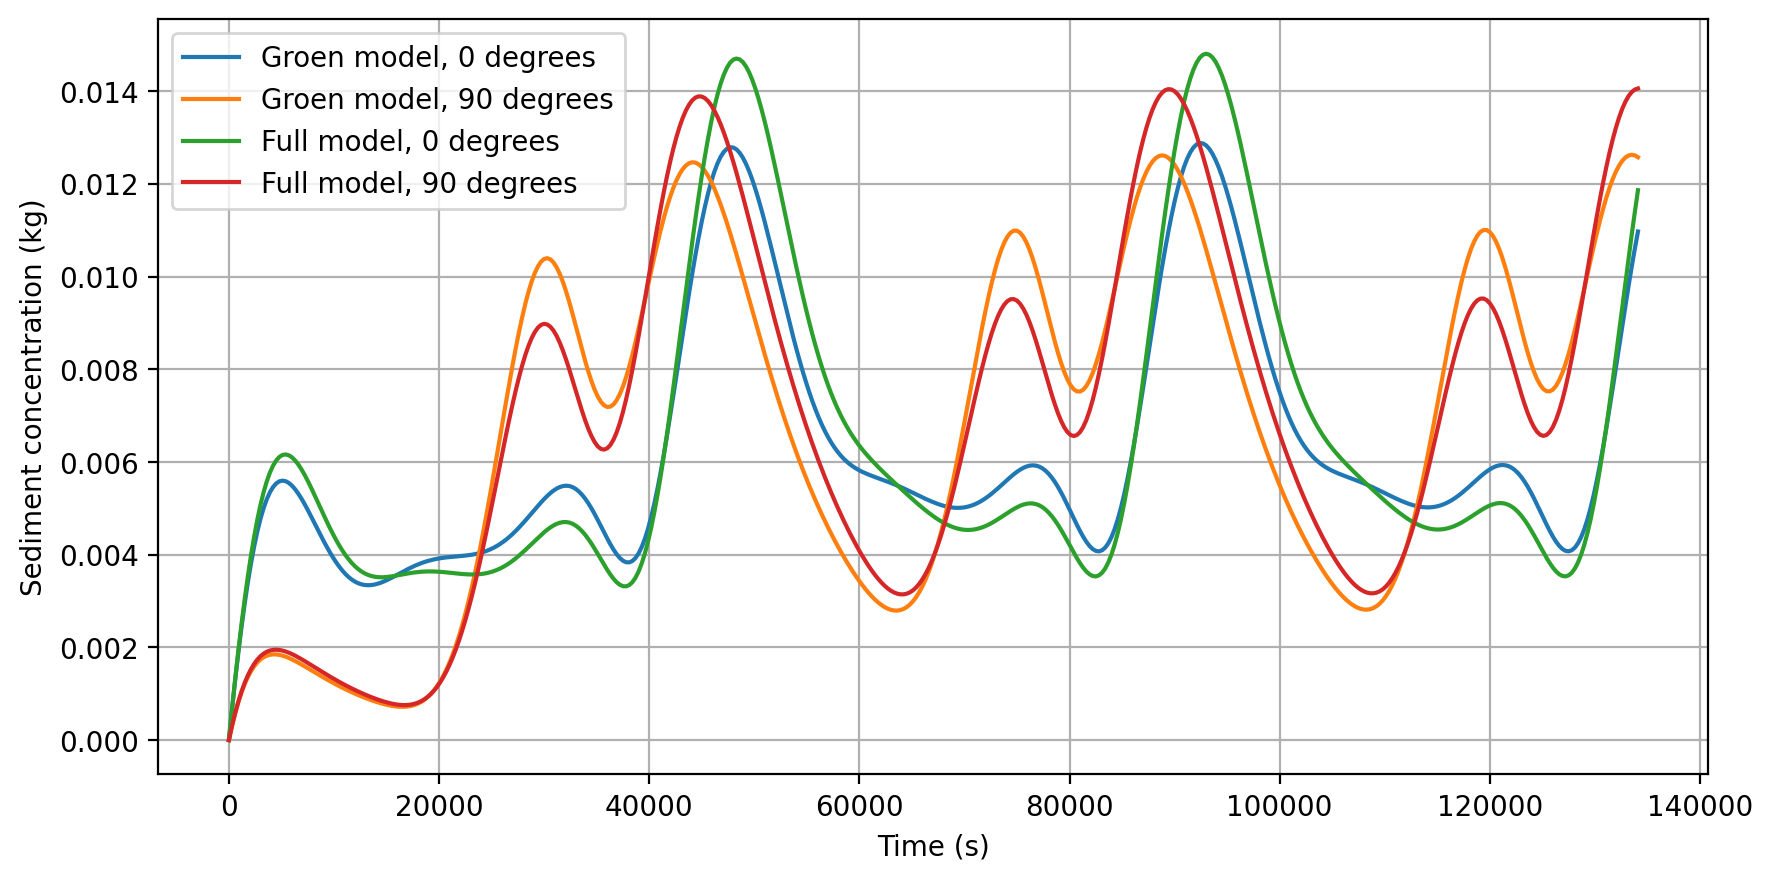

In [32]:
#Plot the sediment concentration
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 200
matplotlib.rcParams['lines.linewidth'] = 1.5

index = 15

plt.plot(tgroen0, Cgroen0[index], label='Groen model, 0 degrees')
plt.plot(tgroen90, Cgroen90[index], label='Groen model, 90 degrees')
plt.plot(tfull0, Cfull0[index], label='Full model, 0 degrees')
plt.plot(tfull90, Cfull90[index], label='Full model, 90 degrees')
plt.grid()
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel('Sediment concentration (kg)')

Text(0, 0.5, 'Sediment transport (kg m/s)')

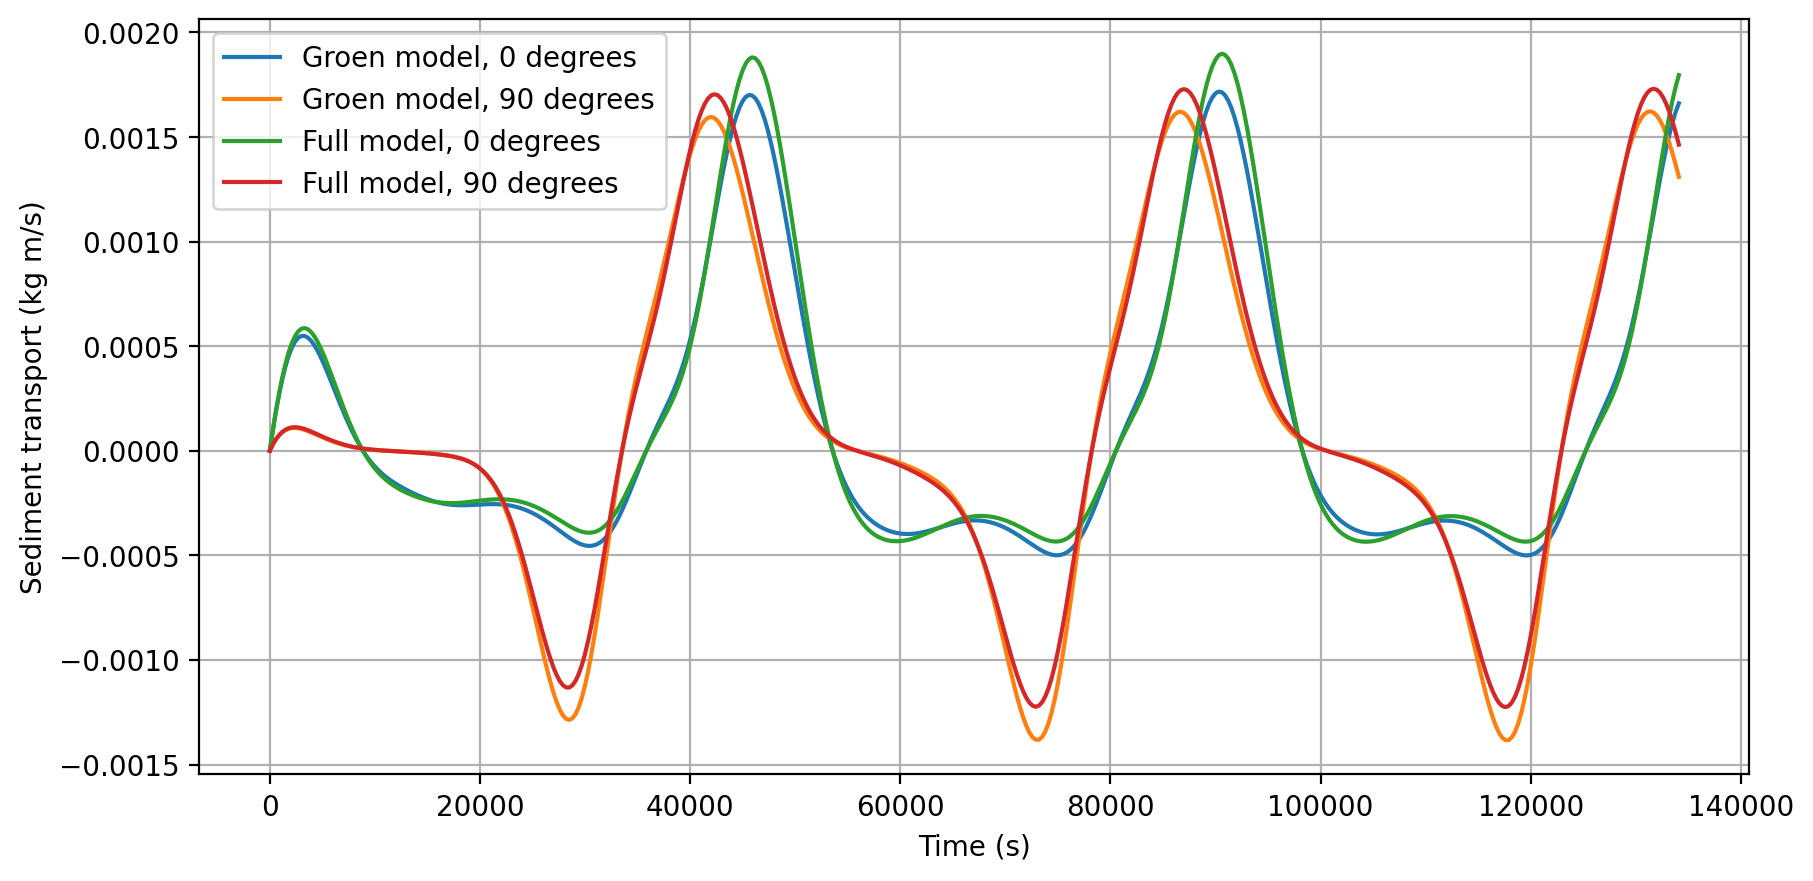

In [33]:
#Plot the sediment transport 
index = 15

plt.plot(tgroen0, Qsgroen0[index], label='Groen model, 0 degrees')
plt.plot(tgroen90, Qsgroen90[index], label='Groen model, 90 degrees')
plt.plot(tfull0, Qsfull0[index], label='Full model, 0 degrees')
plt.plot(tfull90, Qsfull90[index], label='Full model, 90 degrees')
plt.grid()
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel('Sediment transport (kg m/s)')

Text(0, 0.5, 'Mean sediment transport (kg m)')

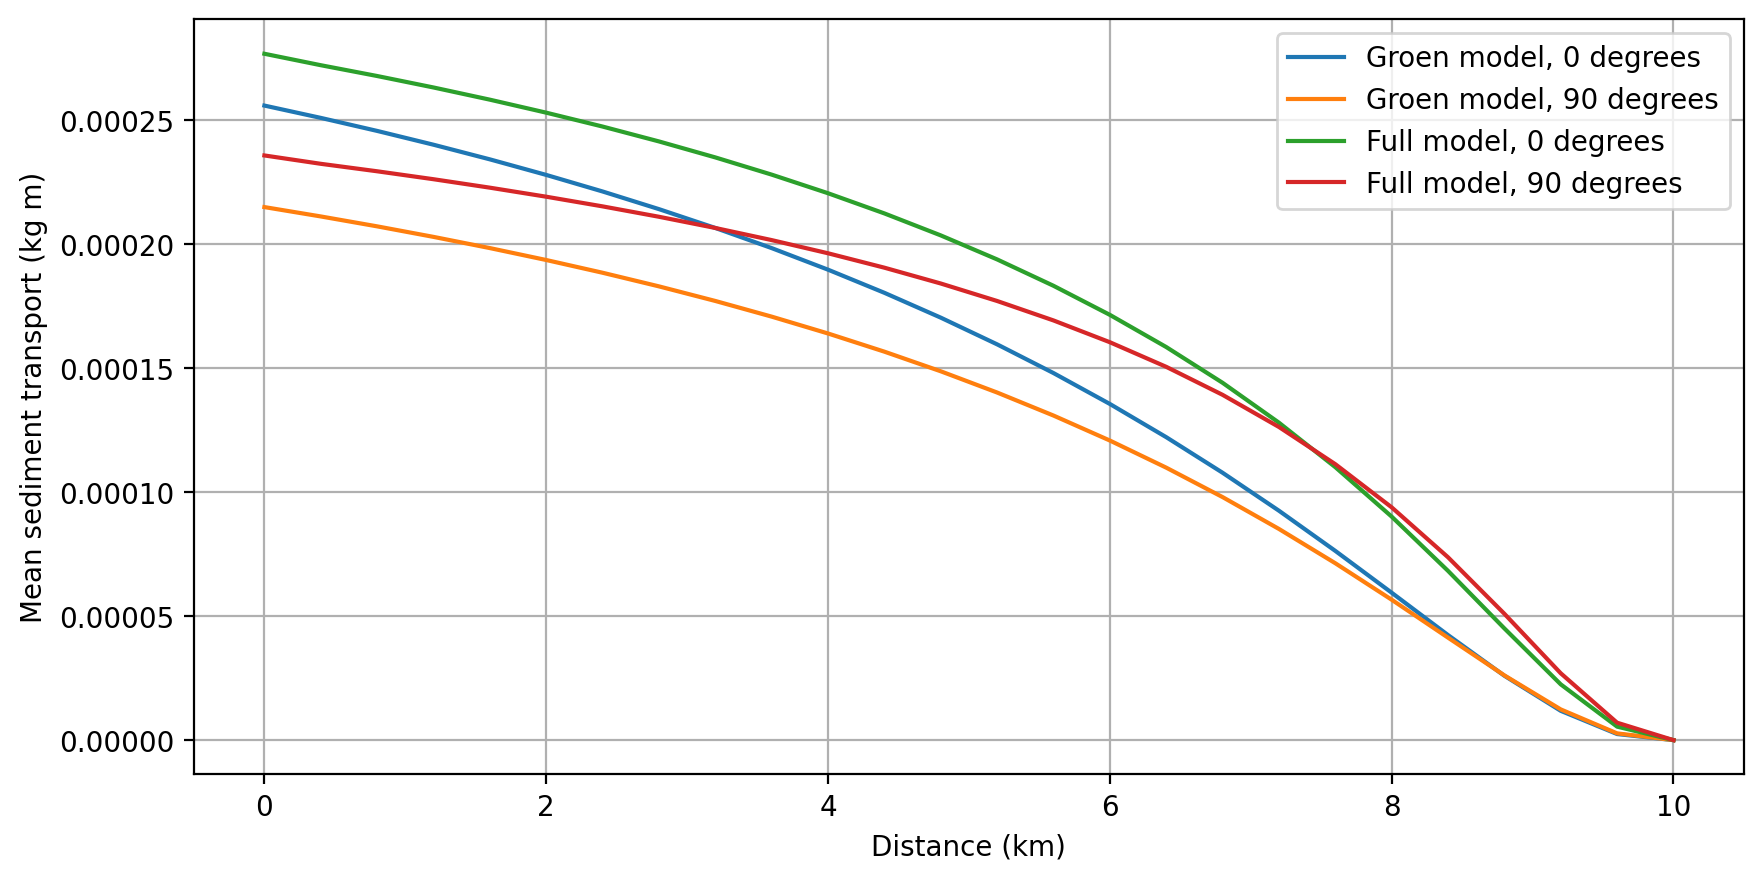

In [34]:
#Plot the mean sediment transport 
plt.plot(np.arange(0, 1e4+400, 400)/1e3, Qsmeangroen0, label='Groen model, 0 degrees')
plt.plot(np.arange(0, 1e4+400, 400)/1e3, Qsmeangroen90, label='Groen model, 90 degrees')
plt.plot(np.arange(0, 1e4+400, 400)/1e3, Qsmeanfull0, label='Full model, 0 degrees')
plt.plot(np.arange(0, 1e4+400, 400)/1e3, Qsmeanfull90, label='Full model, 90 degrees')
plt.grid()
plt.legend()
plt.xlabel("Distance (km)")
plt.ylabel('Mean sediment transport (kg m)')

Text(0, 0.5, 'Flow velocity')

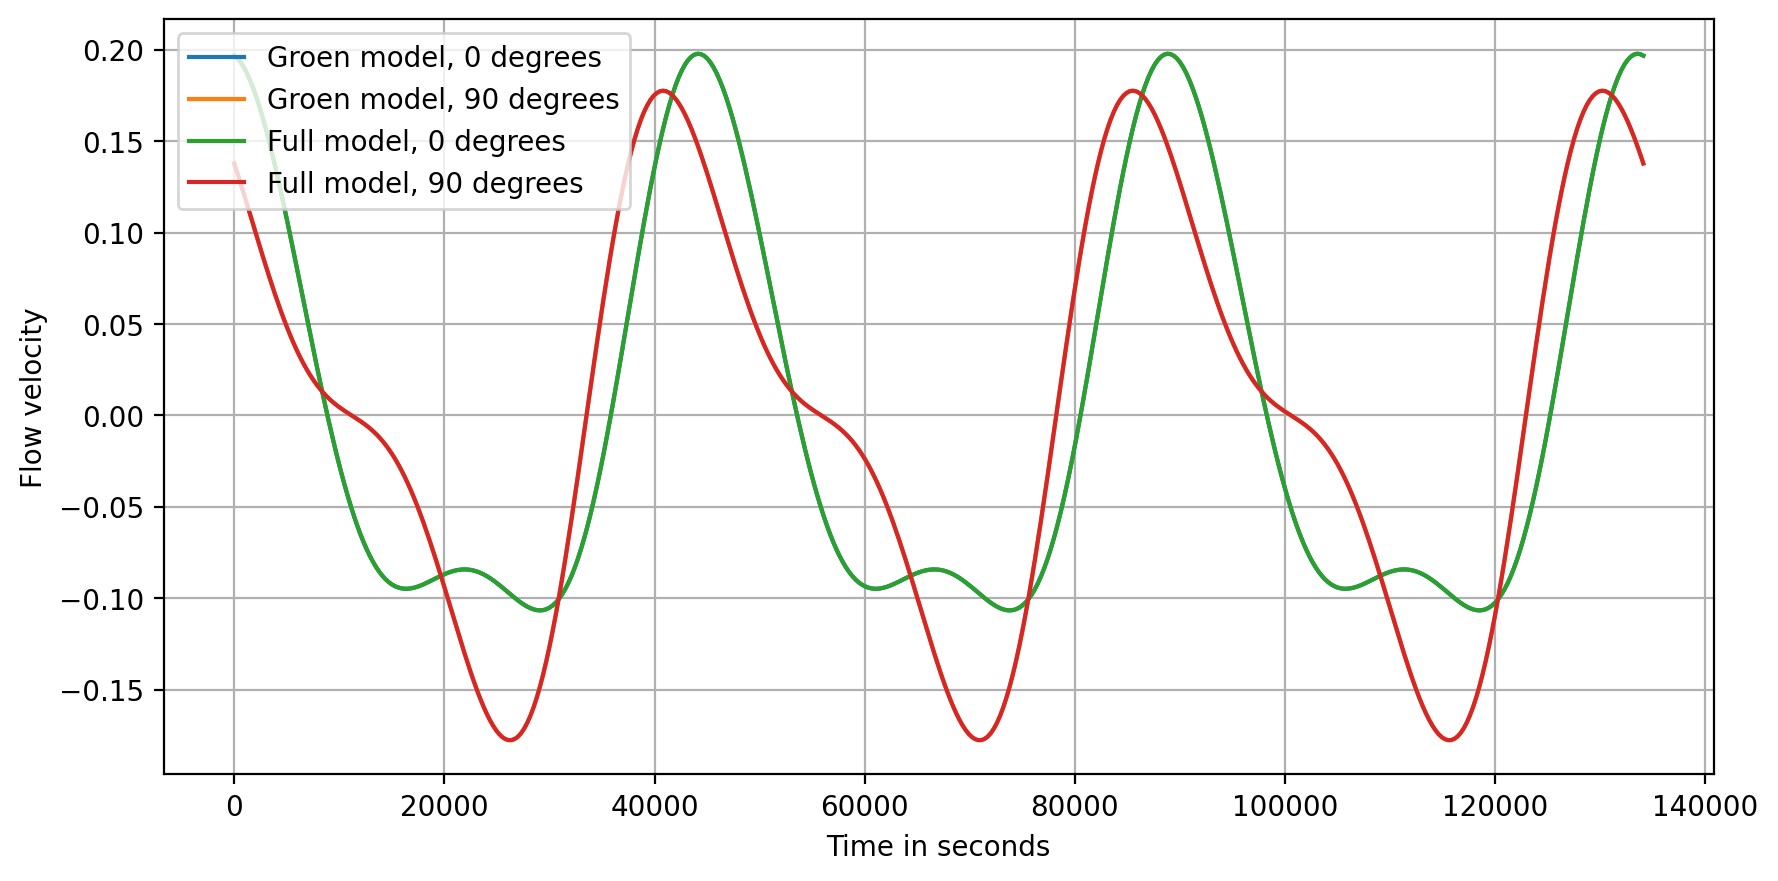

In [35]:
#Plot the flow velocity, not necessary for this exercise I think 
index = 0

plt.plot(tgroen0, Ugroen0[index], label='Groen model, 0 degrees')
plt.plot(tgroen90, Ugroen90[index], label='Groen model, 90 degrees')
plt.plot(tfull0, Ufull0[index], label='Full model, 0 degrees')
plt.plot(tfull90, Ufull90[index], label='Full model, 90 degrees')
plt.grid()
plt.legend()
plt.xlabel("Time in seconds")
plt.ylabel('Flow velocity')

# B. 

In [11]:
#Run full model and groen's model for 0 and 90 degrees and M4 amplitude is 0 m 
tfull0_amp0, Cfull0_amp0, Qsfull0_amp0, Ufull0_amp0, Qsmeanfull0_amp0 = get_Q_arr_full(Ws=1e-3, alpha=1e-4, Kv=1e-2, phaseD1=0, phaseM2=0, phaseM4=0, ampM4=0)
tgroen0_amp0, Cgroen0_amp0, Qsgroen0_amp0, Ugroen0_amp0, Qsmeangroen0_amp0 = get_Q_arr(Ws=1e-3, alpha=1e-4, Kv=1e-2, phaseD1=0, phaseM2=0, phaseM4=0, ampM4=0)
tfull90_amp0, Cfull90_amp0, Qsfull90_amp0, Ufull90_amp0, Qsmeanfull90_amp0 = get_Q_arr_full(Ws=1e-3, alpha=1e-4, Kv=1e-2, phaseD1=0, phaseM2=0, phaseM4=np.pi/2, ampM4=0)
tgroen90_amp0, Cgroen90_amp0, Qsgroen90_amp0, Ugroen90_amp0, Qsmeangroen90_amp0 = get_Q_arr(Ws=1e-3, alpha=1e-4, Kv=1e-2, phaseD1=0, phaseM2=0, phaseM4=np.pi/2, ampM4=0)

Text(0, 0.5, 'Flow velocity (m/s)')

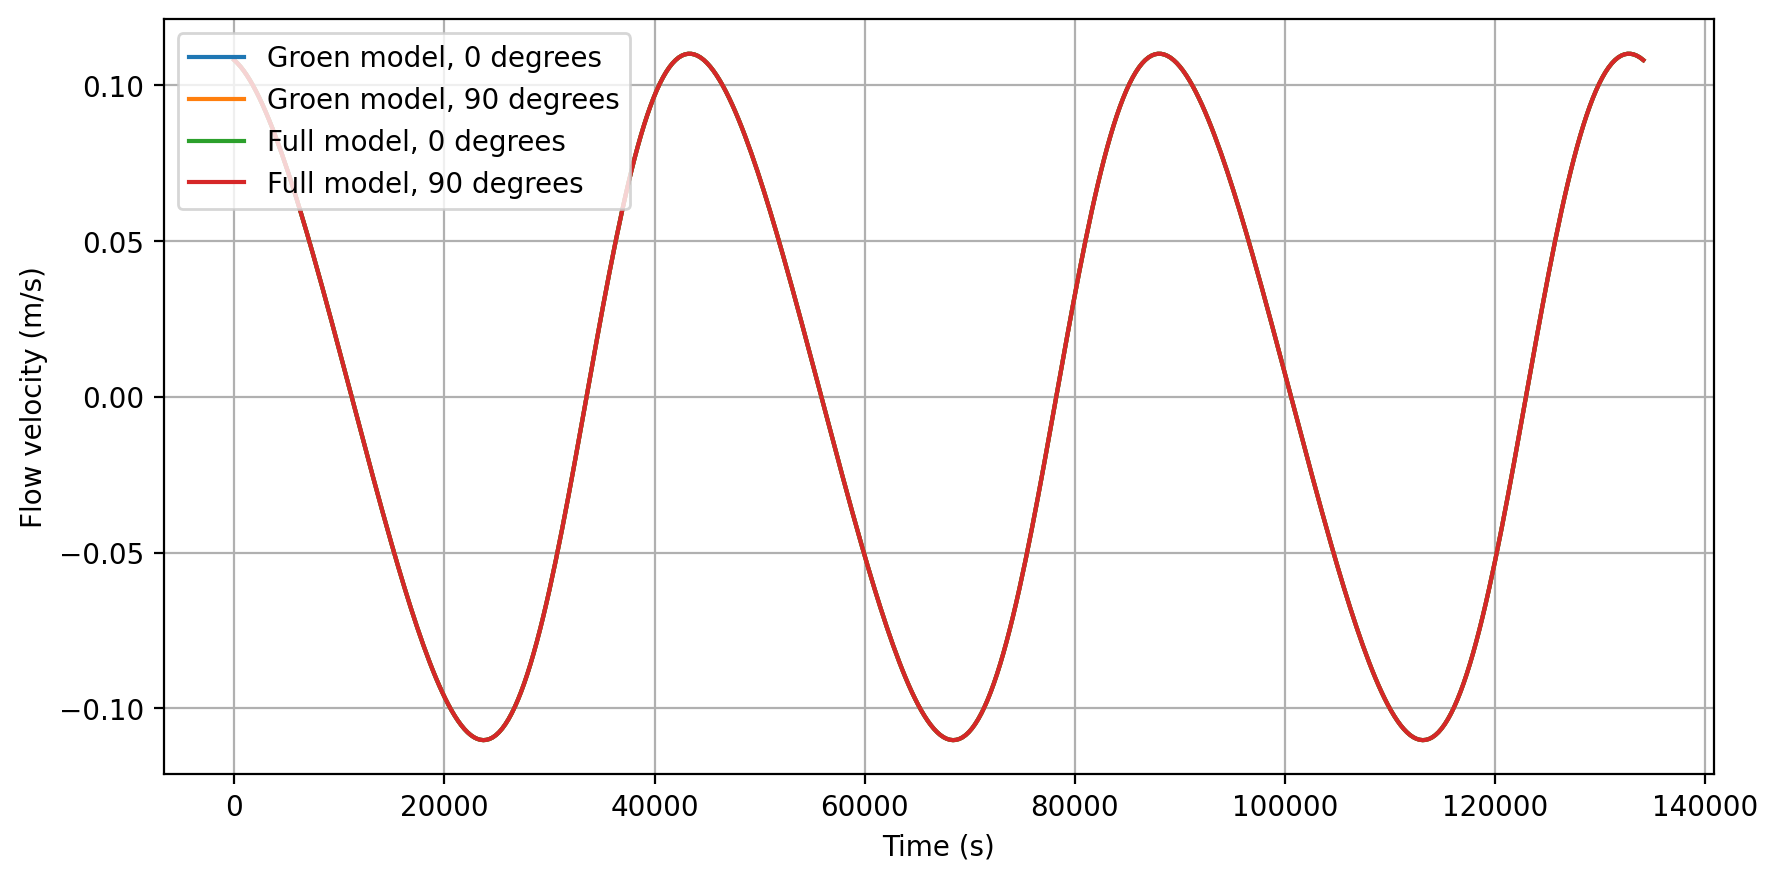

In [36]:
#Plot the flow velocity
index = 15

plt.plot(tgroen0_amp0, Ugroen0_amp0[index], label='Groen model, 0 degrees')
plt.plot(tgroen90_amp0, Ugroen90_amp0[index], label='Groen model, 90 degrees')
plt.plot(tfull0_amp0, Ufull0_amp0[index], label='Full model, 0 degrees')
plt.plot(tfull90_amp0, Ufull90_amp0[index], label='Full model, 90 degrees')
plt.grid()
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel('Flow velocity (m/s)')

Text(0, 0.5, 'Sediment transport (kg m/s)')

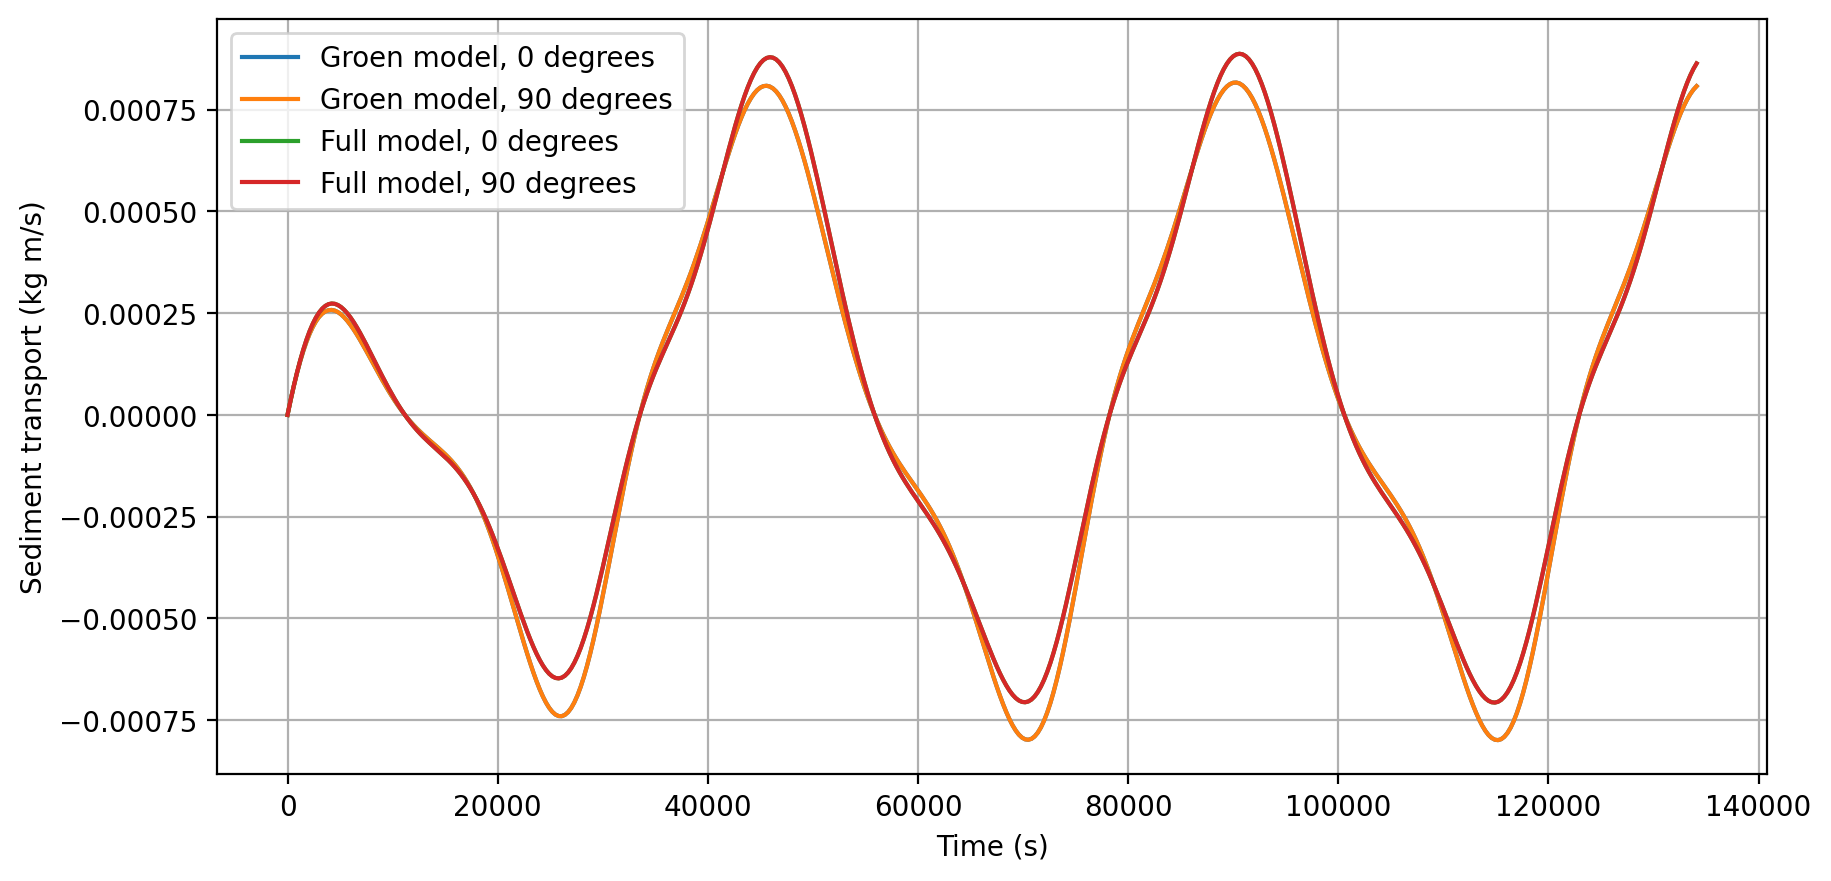

In [37]:
#Plot the flow velocity
index = 15

plt.plot(tgroen0_amp0, Qsgroen0_amp0[index], label='Groen model, 0 degrees')
plt.plot(tgroen90_amp0, Qsgroen90_amp0[index], label='Groen model, 90 degrees')
plt.plot(tfull0_amp0, Qsfull0_amp0[index], label='Full model, 0 degrees')
plt.plot(tfull90_amp0, Qsfull90_amp0[index], label='Full model, 90 degrees')
plt.grid()
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel('Sediment transport (kg m/s)')

#No difference between 0 and 90 degrees --> Logical since there is no m4 amp

Text(0, 0.5, 'Mean sediment transport (kg m)')

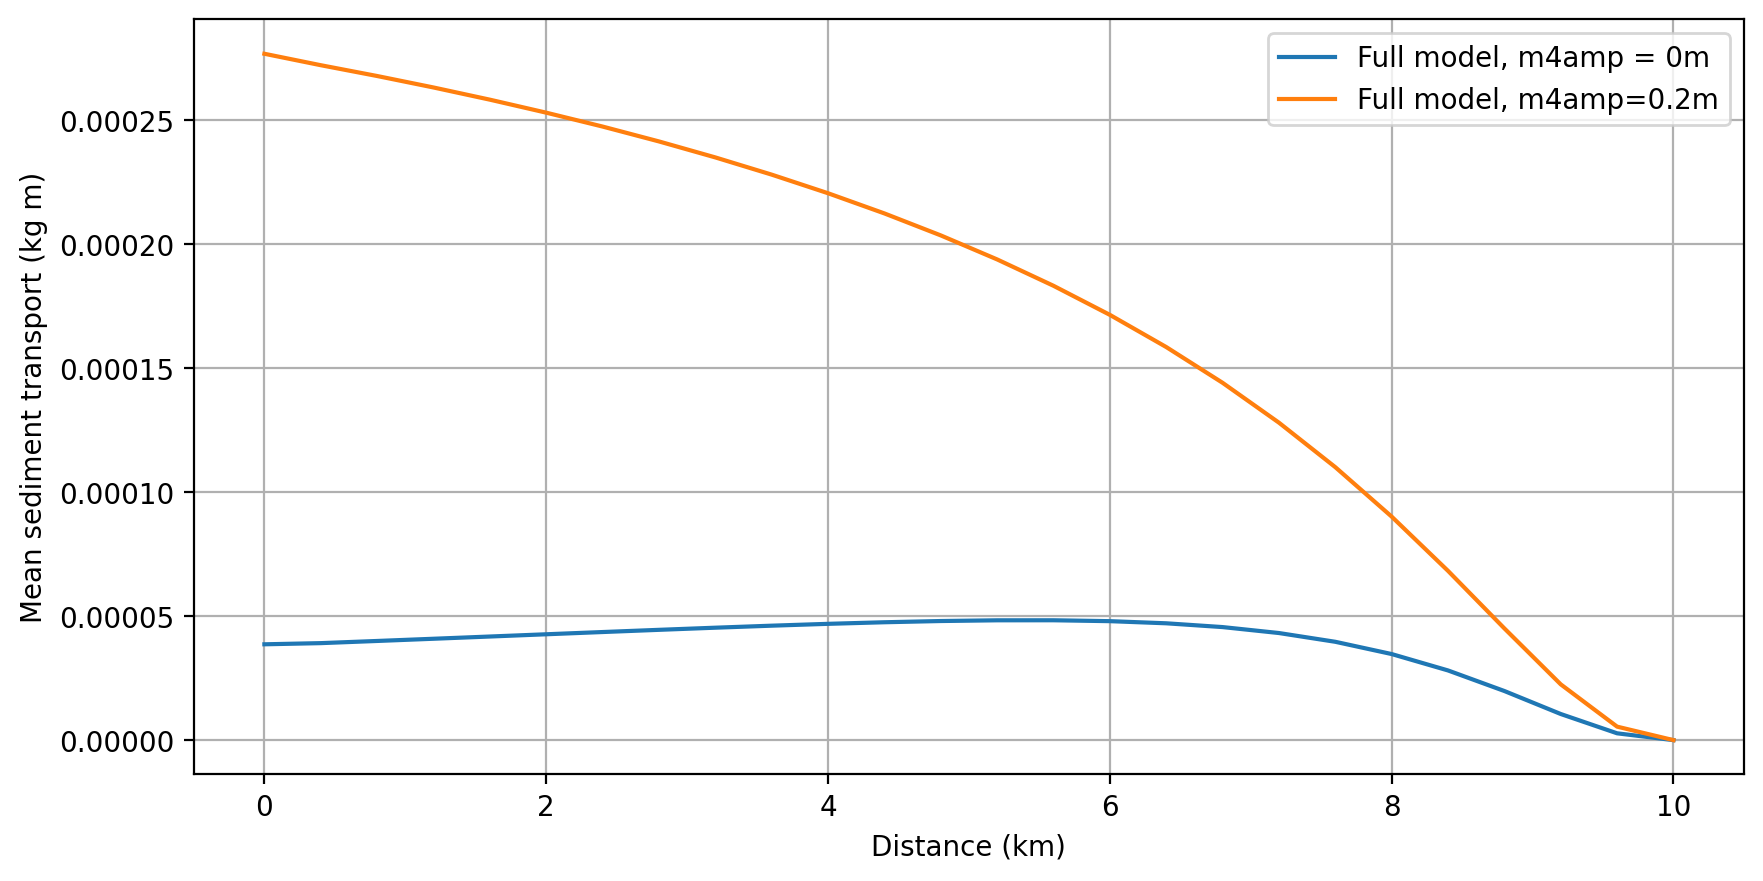

In [38]:
plt.plot(np.arange(0, 1e4+400, 400)/1e3, Qsmeanfull0_amp0, label='Full model, m4amp = 0m')
plt.plot(np.arange(0, 1e4+400, 400)/1e3, Qsmeanfull0, label='Full model, m4amp=0.2m')
plt.grid()
plt.legend()
plt.xlabel('Distance (km)')
plt.ylabel('Mean sediment transport (kg m)')

# C.

In [15]:
#Function from exercise 2 with the harmfit 

# Global Constants
g = 9.81 # m s^-2
Td1  = 24*3600+50*60               #M1 tidal period in seconds
Tm2  = 12*3600+25*60                # M2 tidal period in seconds

def maximumfinder(a):
    if isinstance(a, float):
        amax = a
    else:
        amax = a.max()
    return amax

def stab_test(dt, dx, H):
    hmax = maximumfinder(H)
    CFL = (dt/dx)*(g*hmax)**.5
    
    if CFL < 1:
        return True
    else:
        return False

def simulation(deltaT=30, deltaX=500, Lbasin=2e4, Lb=4e4, B0=1e3, H0=10, M2amp=1, discharge=0, Cd=2.5e-3, constB=True, x_r=28e3, B_r=2.5e3):
    '''
    Function does numerical simulation with given boundary conditions and returns characteristic values/arrays.
    Solving the shallow water equations in shallow basins and estuaries.
    Based on Friedrichs (2011), Chapter 3 in Contemporary Issues in Estuarine Physics.
    
    Input:
        deltaT: time step in s
        deltaX: space step in m
        Lbasin: length basin in m
        Lb: e-folding length scale of basin in 1/m
        B0: width of basin on seaward side in m
        H0: basin depth in m
        M2amp: amplitude of M2 wave on seaward side in m
        discharge: constant discharge of river at landward boundary
        Cd: drag coefficient
        constB: should basin debpth be regarded as constant (=True) or with exponential decay (=False)?
        
    Ouput:
        Dictionary with information of interest about the simulation. Discharge and velocity have dimensions of x
        while Z has dimension of x -1.
    '''
    # defining constants
    time = np.arange(0, 10*Tm2+deltaT, deltaT) # time in seconds
    Nt   = len(time)                     # number of timesteps

    # preparing simulation
    x = np.arange(0, Lbasin+deltaX, deltaX)    # x in meters
    Nx = len(x)                                # number of horizontal locations
    B = np.full(len(x), B0)  # basin width [m]
    if not constB:
        B[x <= x_r] = B0 * np.exp(-x[x <= x_r]/Lb)
        B[x > x_r] = B_r
    H = np.ones(Nx)*H0        # depth [m]
    Z = np.zeros((Nx-1,Nt)) # Z points shifted half a grid point to the right with respect to Q points. we start with Q point, therefore 1 Z point less than Q points.      
    Q = np.zeros((Nx,Nt))
    B_H = np.array(B*H)                                           #volume 
    A = np.matmul(B_H.reshape(len(B_H),1), np.ones((1,Nt)))      # A at Q points 
    P = B.reshape(len(B),1) * np.ones((1,Nt))                    # Wetted perimeter at Q points.

    # Initalize Inertia, Pressure Gradient and Friction for further analysis later on.
    Inertia = np.zeros((Nx,Nt)) 
    PG      = np.zeros((Nx,Nt))
    Fric    = np.zeros((Nx,Nt))

    # Boundary conditions
    Z[0,:] = M2amp * np.sin(2*np.pi*time/Tm2)    # prescribed water levels. This is M2 tide.
    Q[Nx-1,:] = -discharge                       # river discharge; most often river discharge is taken zero.

    hmax = maximumfinder(H)
    courant = np.sqrt(g*hmax*deltaT/deltaX)

    # For numerical part, follow thesis of Speer (1984). Staggered grid. 
    # Z points shifted half deltaX to the right of U points: 
    # Q1 Z1 Q2 Z2 ........ ZN QN+1

    # solve Bdz/dt + dQ/dx=0
    # solve dQ/dt + d/dx Q^2/A = -gA dZ/dx - Cd Q|Q|P/A*A

    # Z is water level, B=estuary width, Q is discharge, A is cross-sectional area, 
    # P is wetted perimeter (~channel width when H/B is small)

    # Numerical scheme from Speer (1984).

    for pt in range(Nt):
        for px in range(2, Nx):
            Z[px-1,pt] = Z[px-1,pt-1] - (deltaT/(0.5*(B[px-1]+B[px])))*(Q[px,pt-1]-Q[px-1,pt-1])/deltaX
            A[px-1,pt] = B[px-1] * (H[px] + 0.5*Z[px-1,pt] + 0.5*Z[px-2,pt])           # A at Q points
            P[px-1,pt] = B[px-1] + 2*H[px-1] + Z[px-1,pt] + Z[px-2,pt]                 # P at Q points

            Inertia[px-1,pt]=(Q[px-1,pt]-Q[px-1,pt-1])/deltaT
            PG[px-1,pt]=-9.81*A[px-1,pt]*(1/deltaX)*(Z[px-1,pt]-Z[px-2,pt])
            Fric[px-1,pt]=-Cd*abs(Q[px-1,pt-1])*Q[px-1,pt-1]*P[px-1,pt-1]/(A[px-1,pt-1]*A[px-1,pt-1])

            Q[px-1,pt]= (Q[px-1,pt-1]                                           # Inertia
                - 9.81*A[px-1,pt]*(deltaT/deltaX)*(Z[px-1,pt]-Z[px-2,pt])       # Pressure gradient
                - Cd*deltaT*abs(Q[px-1,pt-1])*Q[px-1,pt-1]*P[px-1,pt-1]/(A[px-1,pt-1]*A[px-1,pt-1]))    # Friction

        Q[0,pt]=Q[1,pt]+B[0]*deltaX*(Z[0,pt]-Z[0,pt-1])/deltaT

    U=Q/A         # Flow velocity in m/s
    
    # test stability
    water_height = Z + hmax # TODO: oversimplified, arrays Z+H should be added properly
    if not stab_test(deltaT, deltaX, water_height):
        print("Unstable system!")       
    
    # define dictionary that is about to be returned, can be expanded if additional parameters are required
    returndict = {
        'Position': x, 'Time': time, 'Discharge': Q, 'Water_level': Z, 'Velocity': U
    }
    return returndict

# fit tidal constituents
def harmfit(invariant, *args):
    # a0, Cn, and Dn are the estimated amplitudes and phases of the constituents
    # wn are the angular frequencies of the consistuents
    # t is the time vector
    # output = mean + sum_k=1^k=Nharm Cn*sin(wn(k)*t) + Dn*cos(wn(k)*t)

    if len(args) == 1:
        args = tuple(args[0])

    t = invariant["timesteps"]
    wn = invariant["wn"]

    in_args = np.array(args[1:])

    a0 = args[0]
    Cn, Dn = np.split(in_args, 2)
    
    ts = np.array(t)
    
    test = np.empty(len(t))
    test.fill(a0)

    for k in range(len(Cn)):
        test = test + Cn[k] * np.sin(wn[k] * ts) + Dn[k] * np.cos(wn[k] * ts)
    return test

def tidefit(wn_vals, time_arr, ssh):
    '''
    Fits frequences to sea surface height.
    Input:
        wn_vals: array of frequencies to be fitted
        time_arr: arr of time points of the data to be fitted to.
        ssh: array sea surface height to which should be fitted. Same size as time_arr.
    Returns:
        array fitted parameters in form of coeffin and their respective covariance matrix.
    '''
    # fit parameters preparation
    a0 = [1]
    Cn, Dn = np.full(len(wn_vals), 1), np.full(len(wn_vals), 1)
    coefin = np.concatenate((a0, Cn, Dn))
    indep = {"timesteps": time_arr, "wn": wn_vals}

    # fit
    popt, pcov = optimize.curve_fit(harmfit, indep, ssh, coefin)
    return popt, pcov


def fit_sim_1x(t, z, x_idx=-1):
    '''
    Fits frequencies (for now just M2, M4, M6) to the time evolution of sea surface elevation at one position.
    Input:
        t: time array of data to be fitted
        z: array sea surface height with dimension #positions*#time-points. Same shape as from func "simulation".
        x_idx: index of position to be fitted to. Defaults to last index.
    '''
    per_vals = np.array([Tm2, Tm2/2, Tm2/3]) # period array with M2 Period and higher Harmonics
    wn_vals = 2 * np.pi / per_vals # frequencies f = 1/T converted from period
    popt, pcov = tidefit(wn_vals, t, z[x_idx])
    perr = np.sqrt(np.diag(pcov))
    return popt, perr

def par2amp(par, upar):
    '''
    Takes parameters as returned from func tidefit and returns the amplitude (and uncertainty) of each constituent.
    '''
    a0 = np.array([par[0]])
    u_a0 = np.array([upar[0]])
    Cn, Dn = np.split(par[1:], 2)
    u_Cn, u_Dn = np.split(upar[1:], 2)
    amplitude = np.sqrt(Cn ** 2 + Dn ** 2)
    np.seterr(invalid='ignore') #hacky way to not show warnings anymore
    u_amplitude = 1 / amplitude * np.sqrt((Cn * u_Cn)**2 + (Dn * u_Dn)**2)
    np.seterr(invalid='warn') # turn on warnings again
    return np.concatenate((a0, amplitude)), np.concatenate((u_a0, u_amplitude))

def par2phase(par, upar):
    '''
    Takes parameters as returned from func tidefit and returns the phase (and uncertainty) of each constituent.
    TODO: function not used yet
    '''
    a0 = par[0]
    u_a0 = upar[0]
    Cn, Dn = np.split(par[1:], 2)
    u_Cn, u_Dn = np.split(upar[1:], 2)
    phases = np.arctan2(Cn, Dn)
    np.seterr(invalid='ignore') #hacky way to not show warnings anymore
    # derivative from tan(x/y) is propto sec**2 = arccos**2
    u_phases = np.sqrt((u_Cn * np.arccos(Cn / Dn)**2 / Dn)**2 + (u_Dn * Cn * np.arccos(Cn / Dn) / Dn ** 2))
    # old: np.sqrt((Dn*u_Cn/(Cn**2 + Dn**2))**2 + (Cn*u_Dn/(Cn**2+Dn**2))**2)
    np.seterr(invalid='warn') # turn on warnings again                  
    return phases, u_phases
    
def get_amp_phase(x, t, z):
    '''
    Finds fitted amplitude and phase for every position x in z vector.
    '''
    length = len(z[:, 0])
    amp_arr = np.zeros(length, dtype=object)
    uamp_arr = np.zeros(length, dtype=object)
    phase_arr = np.zeros(length, dtype=object)
    uphase_arr = np.zeros(length, dtype=object)
    for xidx in range(length):
        popt, perr = fit_sim_1x(t, z, x_idx=xidx)
        amp_arr[xidx], uamp_arr[xidx] = par2amp(popt, perr)
        phase_arr[xidx], uphase_arr[xidx] = par2phase(popt, perr)
    return amp_arr, uamp_arr, phase_arr, uphase_arr

def rearr_arr(x, ux, xidx=0):
    '''
    Basically transposes array of array and returns only array with index idx. Defaults to returning only M2 amplitude.
    '''
    newx = np.zeros(len(x))
    newux = np.zeros(len(ux))
    for idx, item in enumerate(x):
        newx[idx] = item[xidx]
    for idx, item in enumerate(ux):
        newux[idx] = item[xidx]
    return newx, newux

def get_full_fit(x, t, z):
    '''
    Returns amplitudes (and uncertainties) and phases (and uncertainties) of all positions x in z-array).
    Input:
        x: Positon array of simulation where amplitudes are available.
        t: Time array of simulation where amplitudes are available.
        z: Sea surface height of simulation. Dimension x*t.
    Returns:
        Dictionary with all relevant fitting information. For each position point in x, a fit was done.
        Therefore, all arrays in the dictionary have the same size as len(z[:, 0]) which is len(x) or len(x)-1.
        The first is true for discharges etc while the latter is true for SSH.
    '''
    amp, uamp, phase, uphase = get_amp_phase(x, t, z)
    a0, ua0 = rearr_arr(amp, uamp, xidx=0)
    m2amp, um2amp = rearr_arr(amp, uamp, xidx=1)
    m4amp, um4amp = rearr_arr(amp, uamp, xidx=2)
    m6amp, um6amp = rearr_arr(amp, uamp, xidx=3)
    m2phase, um2phase = rearr_arr(phase, uphase, xidx=0)
    m4phase, um4phase = rearr_arr(phase, uphase, xidx=1)
    m6phase, um6phase = rearr_arr(phase, uphase, xidx=2)
    returndict = {"Mean Amplitude": a0, "M2 Amplitude": m2amp, "M4 Amplitude": m4amp, "M6 Amplitude": m6amp,
                  "Mean Amplitude Uncertainty": ua0, "M2 Amplitude Uncertainty": um2amp, "M4 Amplitude Uncertainty": um4amp, "M6 Amplitude Uncertainty": um6amp,
                  "M2 Phase": m2phase, "M4 Phase": m4phase, "M6 Phase": m6phase,
                  "M2 Phase Uncertainty": um2phase, "M4 Phase Uncertainty": um4phase, "M6 Phase Uncertainty": um6phase}
    return returndict

In [16]:
#Create function where only M2 u is used 
def get_Q_arr_full_m2(Ws=5e-4, alpha=1e-4, Kv=1e-2, phaseD1=0, phaseM2=0, phaseM4=np.pi/2, ampD1=0, ampM2=1, ampM4=0.2): #Define amplitude in calling of function 
    '''
    Function to get time, C and Q. 
    Input:
        Ws = 
        alpha = 
        Kv = 
    Output: 
        t = 
        C = 
        Q = 
    '''

    T = (12*60+25)*60        # We model only the M2 and M4 tide. Time is in seconds. 
    Tadapt = Kv/Ws**2
    Test = 3*Tadapt          # Estimated adaptation time scale to get to equilibrium C
    Tnt  = np.ceil(Test/T)
    Tend = 3*Tnt*T           # Depends on Ws and Kv. Enough time to Equilibrium C. 
    deltaT = 300             # Time step of 5 minutes
    t  = np.arange(0, Tend+deltaT, deltaT)
    Nt = len(t)

#Comment the amplitude here, since it is already specified in the calling of the function 
#     ampD1 = 0            # in part 1 and 2 D1=0. Depending on your estuary, you might want to prescribe D1 for part 3. 
#     ampM2 = 1
#     ampM4 = 0.2
    
    Z = ampD1*np.sin(np.pi*t/T + phaseD1)+ ampM2*np.sin(2*np.pi*t/T + phaseM2)+ ampM4*np.sin(4*np.pi*t/T + phaseM4)          # Waterlevel prescribed as sine function. 
    dZdt = ampD1*1*np.pi/T*np.cos(np.pi*t/T+ phaseD1)+ ampM2*2*np.pi/T*np.cos(2*np.pi*t/T+ phaseM2)+ ampM4*4*np.pi/T*np.cos(4*np.pi*t/T + phaseM4)  # Flow velocity will behave as a cosine function. 
    
    L  = 1e4                     # We model a simple basin with a length of 10 km
    dx = 400                     # Grid distance
    x  = np.arange(0, L+dx, dx)  # x-coordinate. Seaward end is at x=L, landward end at x=0. 
    Nx = len(x)                  # array of 26 long
    H = 10-8e-4 * x             # Bottom profile. Linear sloping bottom. 2 m deep near landward boundary, 10 m deep near inlet. 
    dHdx = np.ones(Nx) * -8e-4
    
    U = HydroModel(t,Z,dZdt,H,dHdx,x,dx) # Calculating flow velocities 
    velocity_amplitudes=get_full_fit(x, t ,U)
    m2_amp=velocity_amplitudes['M2 Amplitude']
    m2_ph=velocity_amplitudes['M2 Phase']
    U_m2 = np.zeros((Nx, Nt))
    for i in range(len(m2_amp)):
        U_m2[i, :] = m2_amp[i]*np.cos(2*np.pi*t/T + m2_ph[i])
    
    Cgroen = np.zeros((Nx, Nt))
    Qsgroen = np.zeros((Nx,Nt))
    
    for px in range(Nx):
        Cgroen[px,0:Nt],Qsgroen[px,0:Nt] = GroenModel(U_m2[px,0:Nt],t ,deltaT, T, Ws, alpha, Kv) #using groens model to find C and Q
    
    dQsdx, dQsdt = np.gradient(Qsgroen, dx, deltaT) #Calculate the gradient of Qs based on Groen's model 
    
    Cfull = np.zeros((Nx, Nt)) #Make empty lists for the full model 
    Qsfull = np.zeros((Nx, Nt)) #Make empty lists for the full model 
    
    #Run the full model 
    for px in range(Nx):
        Cfull[px,0:Nt],Qsfull[px,0:Nt] = FullModel(U_m2[px,0:Nt],t,deltaT, T, Ws, alpha, Kv, dQsdx[px,0:Nt]) #using groens model to find C and Q
    
    Nsteps = T/deltaT       # Nr of timesteps in one tidal cycle. #added 
    final_cycle = int(-Nsteps) #added
    meanQsfull = np.mean(Qsfull[:,final_cycle:], 1) #added
    return t, Cfull, Qsfull, U_m2, meanQsfull

<ipython-input-15-5ba2afe125dc>:189: RuntimeWarning: divide by zero encountered in divide
  u_amplitude = 1 / amplitude * np.sqrt((Cn * u_Cn)**2 + (Dn * u_Dn)**2)


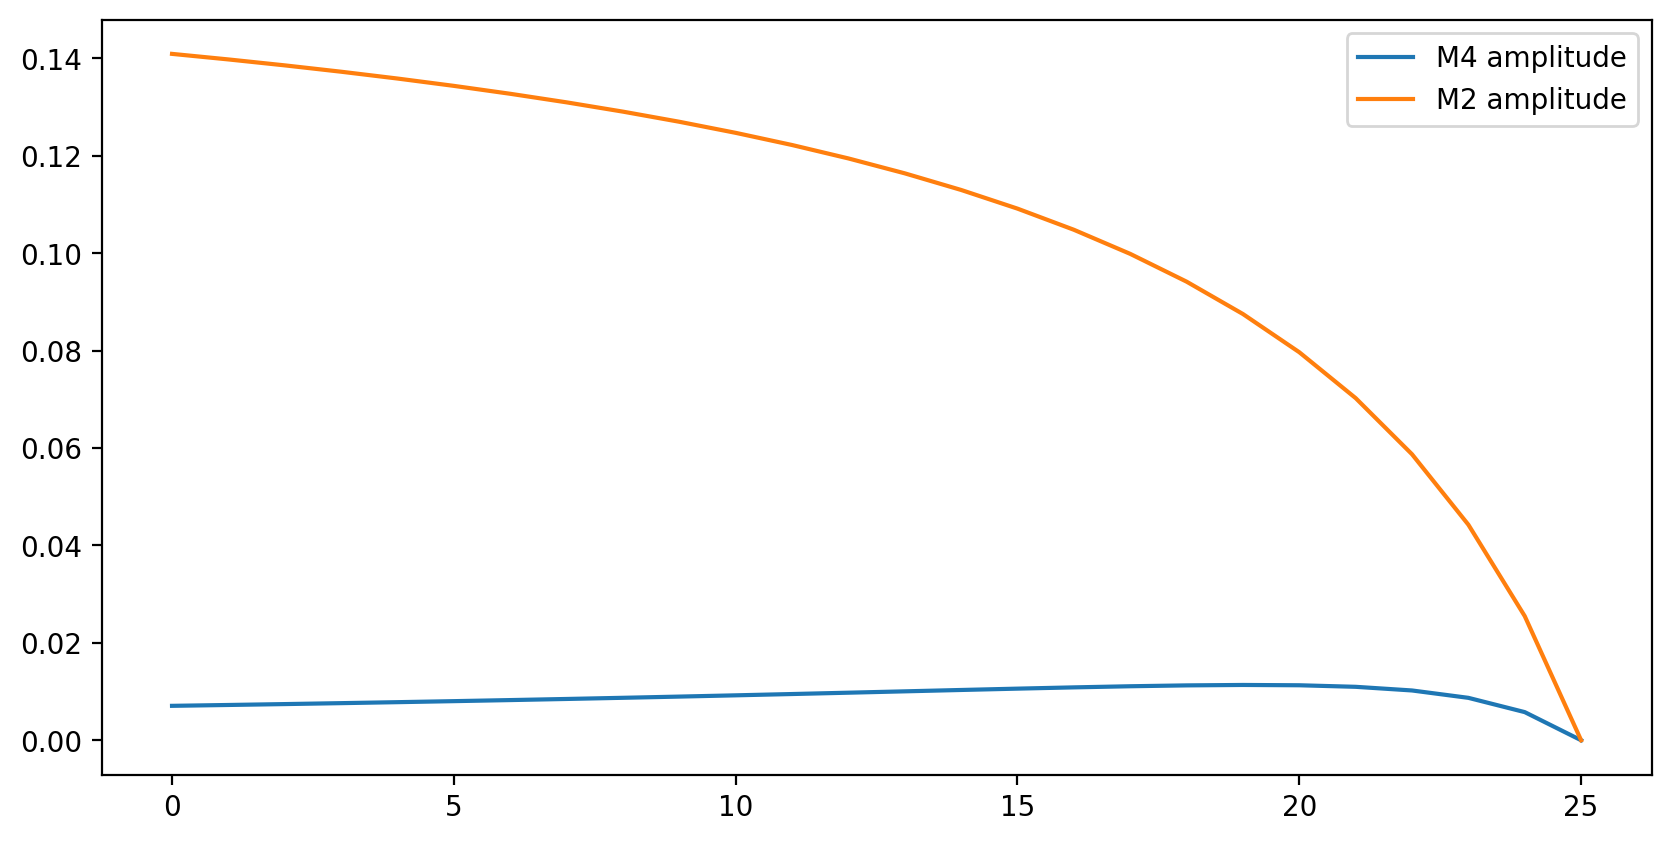

In [39]:
#This code is not nessecary anymore, but it is nice to show the difference between the m2 and m4 amplitude 
#Get the M2 amplitudes of the run 
L  = 1e4                     # We model a simple basin with a length of 10 km
dx = 400                     # Grid distance
x  = np.arange(0, L+dx, dx)

velocity_amplitudes=get_full_fit(x, tfull0_amp0 ,Ufull0_amp0 )

plt.plot(velocity_amplitudes['M4 Amplitude'], label='M4 amplitude')
plt.plot(velocity_amplitudes['M2 Amplitude'], label='M2 amplitude')
plt.legend()

<ipython-input-15-5ba2afe125dc>:189: RuntimeWarning: divide by zero encountered in divide
  u_amplitude = 1 / amplitude * np.sqrt((Cn * u_Cn)**2 + (Dn * u_Dn)**2)


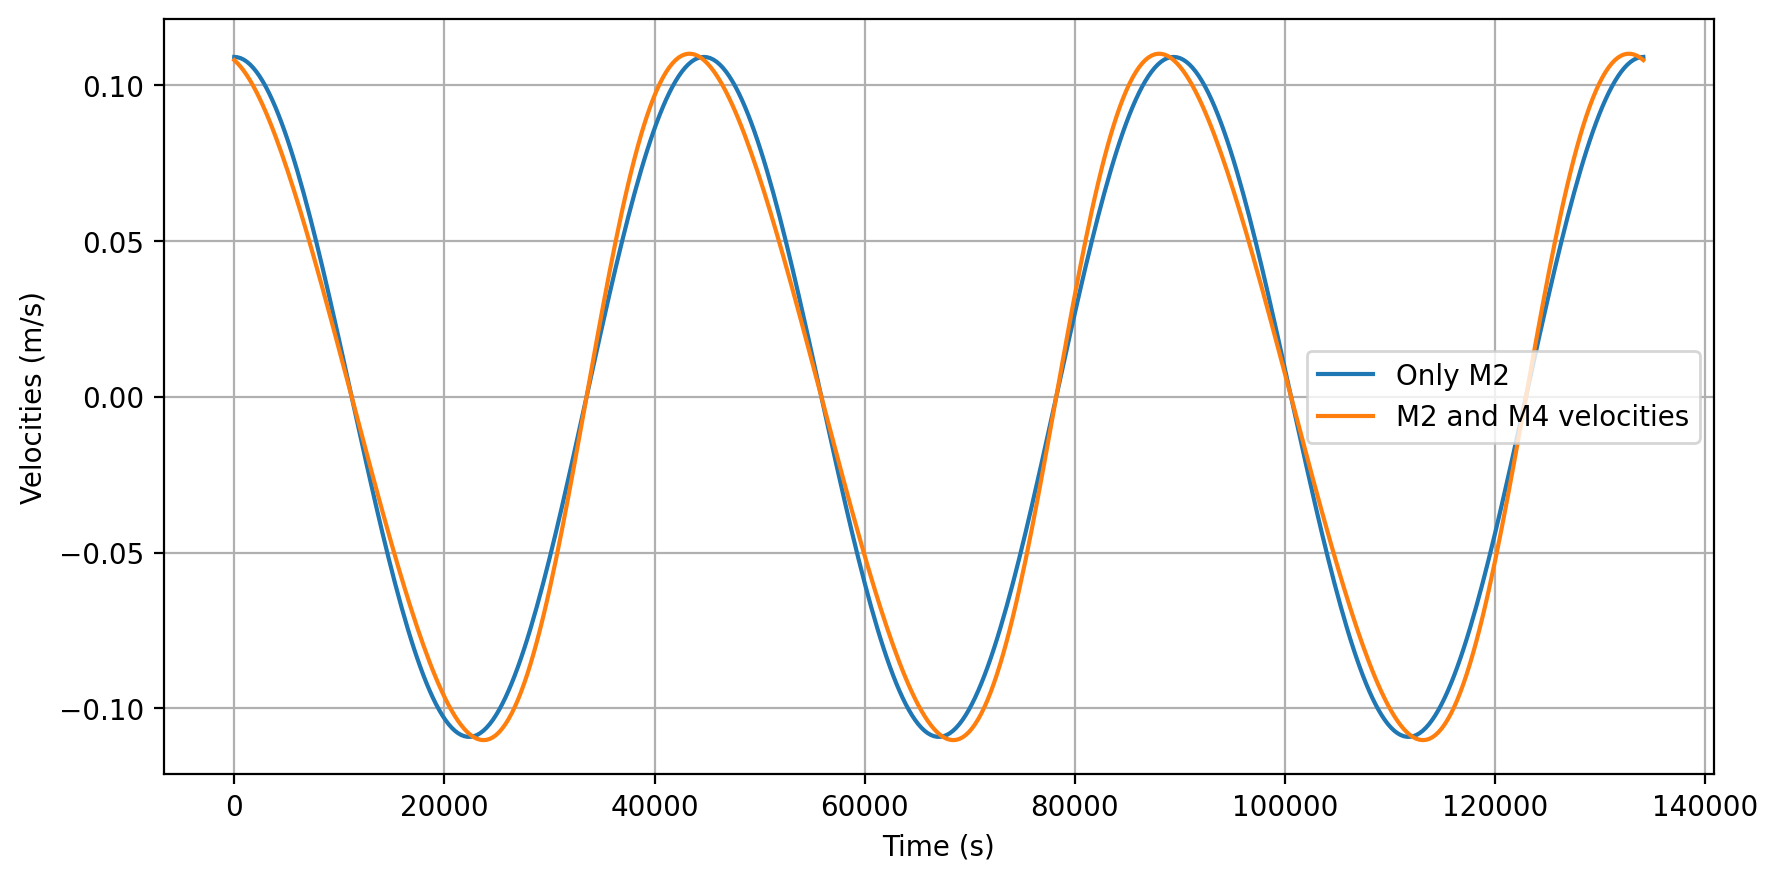

In [42]:
#Run the m2 only model and compare the velocities of the full model with m4amp = 0 and only m2 velocities. 

index=15

tfull0_m2, Cfull0_m2, Qsfull0_m2, Ufull0_m2, Qsmeanfull0_m2 = get_Q_arr_full_m2(Ws=1e-3, alpha=1e-4, Kv=1e-2, phaseD1=0, phaseM2=0, phaseM4=0, ampM4=0)
plt.plot(tfull0_m2, Ufull0_m2[index], label='Only M2')
plt.plot(tfull90_amp0, Ufull90_amp0[index], label='M2 and M4 velocities')
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Velocities (m/s)')
plt.legend()

#The velocities seem to correspond pretty well, so I think the code is correct. 

Text(0, 0.5, 'Mean sediment transport (kg m)')

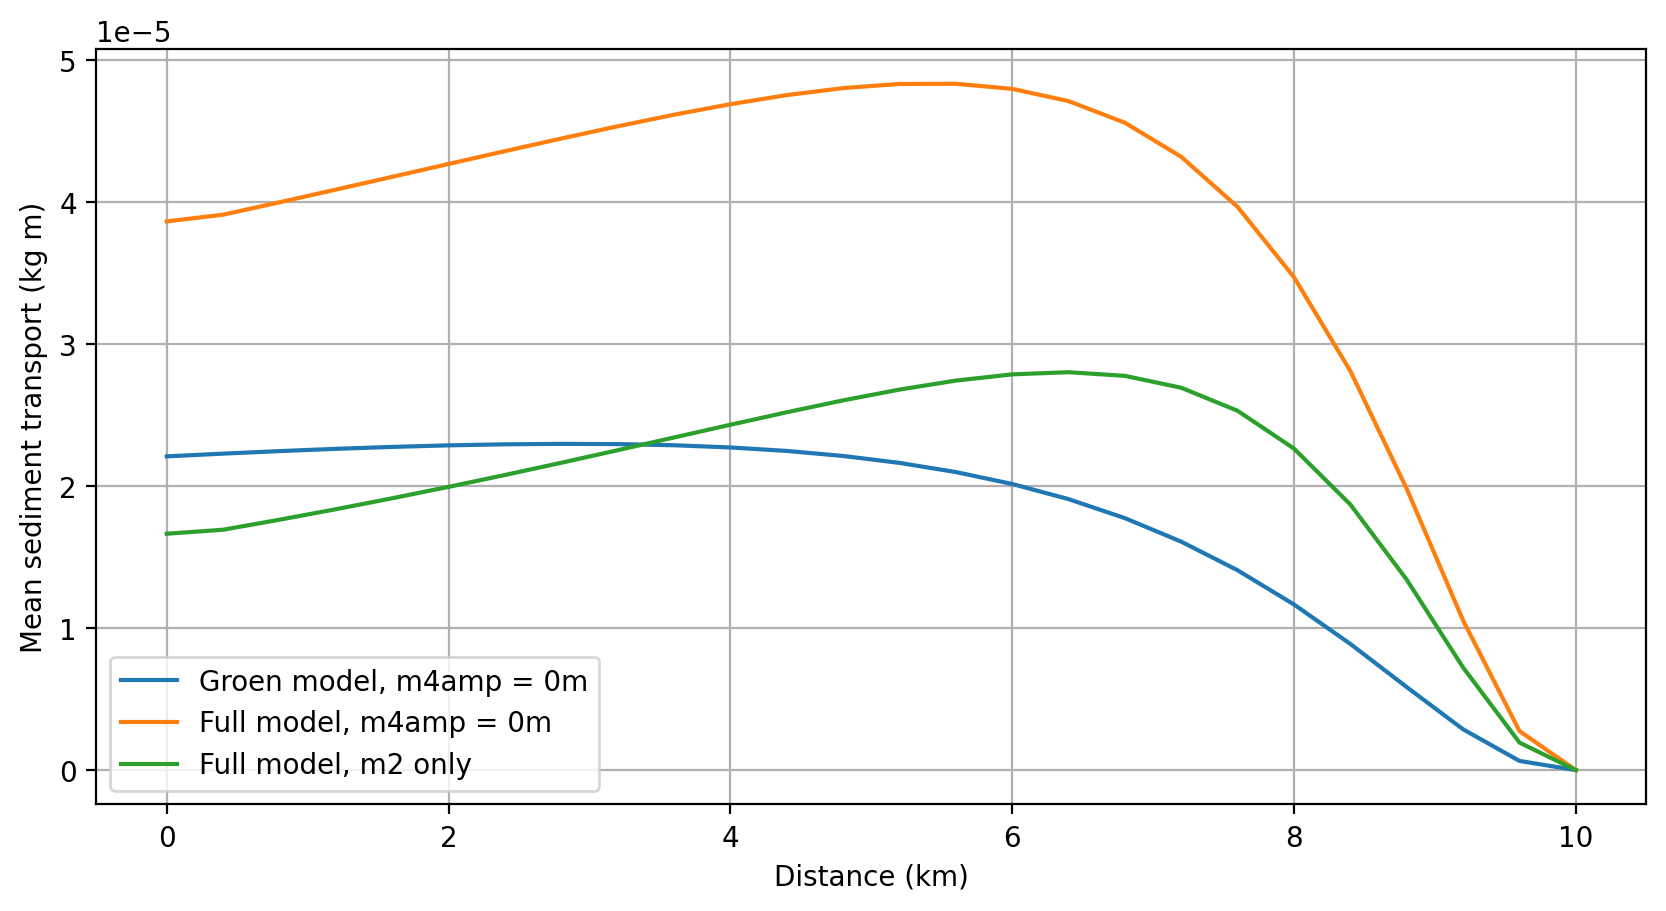

In [43]:
plt.plot(np.arange(0, 1e4+400, 400)/1e3, Qsmeangroen0_amp0, label='Groen model, m4amp = 0m')
plt.plot(np.arange(0, 1e4+400, 400)/1e3, Qsmeanfull0_amp0, label='Full model, m4amp = 0m')
plt.plot(np.arange(0, 1e4+400, 400)/1e3, Qsmeanfull0_m2, label='Full model, m2 only')
plt.grid()
plt.legend()
plt.xlabel('Distance (km)')
plt.ylabel('Mean sediment transport (kg m)')

In [44]:
ws_list=[5e-4, 1e-3, 1.5e-3, 2e-3, 5e-3, 10e-3, 15e-3, 20e-3]
ws_result=[]
for ws_index in ws_list: 
    t_ws_index, C_ws_index, Qs_ws_index, U_ws_index, Qsmean_ws_index = get_Q_arr_full_m2(Ws=ws_index, alpha=1e-4, Kv=1e-2, phaseD1=0, phaseM2=0, phaseM4=0, ampM4=0)
    ws_index_dict={"t":t_ws_index, "C":C_ws_index, "Qs":Qs_ws_index, "U":U_ws_index, "Qsmean":Qsmean_ws_index}
    ws_result.append(ws_index_dict)

0.0005


<ipython-input-15-5ba2afe125dc>:189: RuntimeWarning: divide by zero encountered in divide
  u_amplitude = 1 / amplitude * np.sqrt((Cn * u_Cn)**2 + (Dn * u_Dn)**2)
<ipython-input-15-5ba2afe125dc>:205: RuntimeWarning: divide by zero encountered in divide
  u_phases = np.sqrt((u_Cn * np.arccos(Cn / Dn)**2 / Dn)**2 + (u_Dn * Cn * np.arccos(Cn / Dn) / Dn ** 2))


0.001
0.0015
0.002
0.005
0.01
0.015
0.02


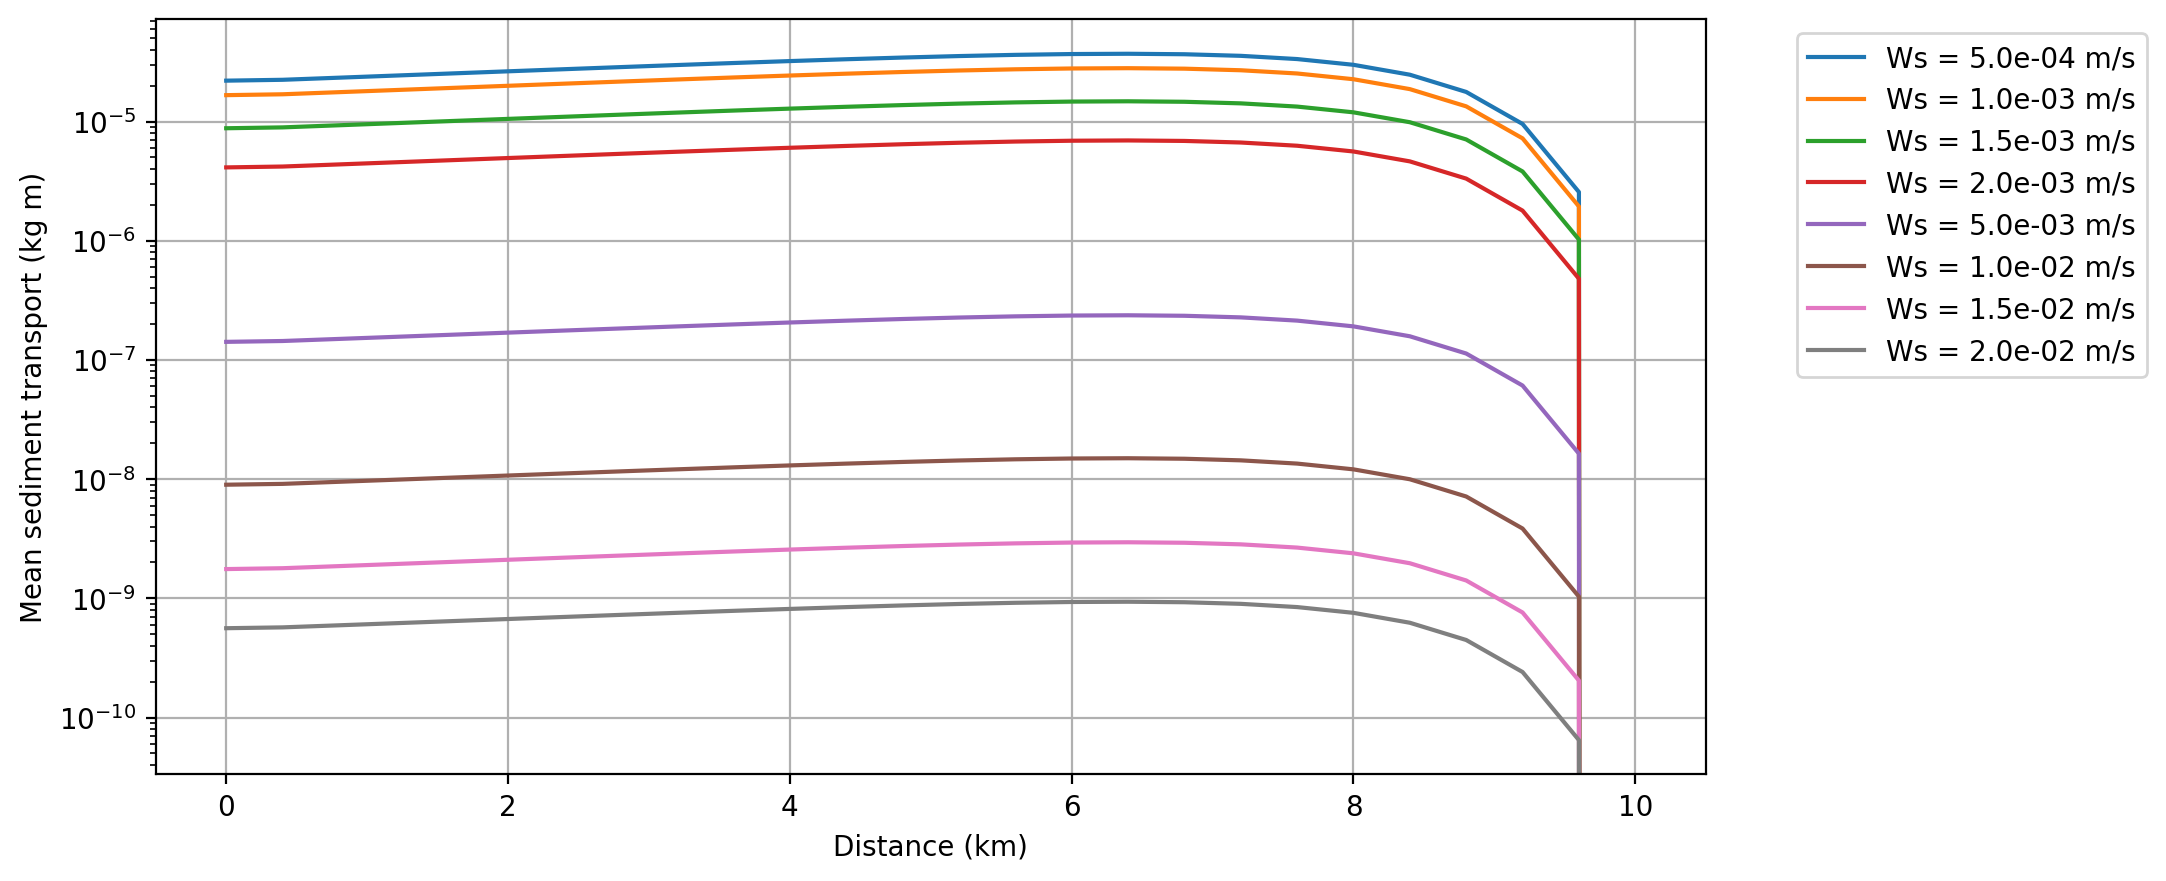

In [45]:
#Plot Qs mean for the different ws 
for idx, val in enumerate(ws_list): #plot mean Qs for different ws
    plt.plot(np.arange(0, 1e4+400, 400)/1e3, ws_result[idx]["Qsmean"], label='Ws = {:0.1e}'.format(val)+' m/s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid(True)
plt.xlabel("Distance (km)")
plt.ylabel("Mean sediment transport (kg m)")
plt.yscale('log')